<a href="https://colab.research.google.com/github/whaledarn/MMRVaccineResearch/blob/main/multitask_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data.xlsx to Data.xlsx


In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
from numpy import array

import os

import matplotlib.pyplot as plt

import pandas as pd
import random

from preproc import tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.metrics import f1_score

# reads files into program
df = pd.read_excel(r'Tweets.xls')
df2 = pd.read_excel(r'Data.xlsx')

# creates a list for tweets, tone, type, and attitude
tweets = list(df['Field'])
tone = list(df2['tone/emotion'])
type = list(df2['type of message'])
attitude = list(df2['attitude toward vaccine'])
# number of tweets
length_of_data = 2997
# seed for randomization
seed = 50


**Aligns each of the labels to its respective tweet and randomizes**

In [ ]:
# tokenizes each tweet
for i in range(0, length_of_data):
    tweets[i] = tokenize(tweets[i])
# maps each tweet to its respective labels and shuffles
mapped = zip(tweets, tone, type, attitude)
mapped = list(mapped)

random.seed(seed)
random.shuffle(mapped)

#unzips the map and sets each dataset to its own list
train_tweets, train_tone, train_type, train_attitude = zip(*mapped[:2100])
validation_tweets, validation_tone, validation_type, validation_attitude = zip(*mapped[2100:2400])
testing_tweets, testing_tone, testing_type, testing_attitude = zip(*mapped[2400:])

**Preprocessing the labels**

In [ ]:
# preprocesses the labels we are testing on

values = array(train_attitude)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_attitude = onehot_encoded

values = array(validation_attitude)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
validation_attitude = onehot_encoded

values = array(testing_attitude)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
testing_attitude = onehot_encoded





values = array(train_tone)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_tone = onehot_encoded

values = array(validation_tone)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
validation_tone = onehot_encoded

values = array(testing_tone)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
testing_tone = onehot_encoded





values = array(train_type)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_type = onehot_encoded

values = array(validation_type)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
validation_type = onehot_encoded

values = array(testing_type)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
testing_type = onehot_encoded



**Preprocessing the data for the model**

In [ ]:

#preprocesses the tweets
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_tweets)
train_tweets = tokenizer.texts_to_sequences(train_tweets)
validation_tweets = tokenizer.texts_to_sequences(validation_tweets)
testing_tweets = tokenizer.texts_to_sequences(testing_tweets)

vocab_size = len(tokenizer.word_index) + 1

# A dictionary mapping words to an integer index
word_index = tokenizer.word_index

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# turns the decoded tweets back to its original tweet
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# preprocesses the data
train_data = keras.preprocessing.sequence.pad_sequences(train_tweets,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=50)

valid_data = keras.preprocessing.sequence.pad_sequences(validation_tweets,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=50)
testing_data = keras.preprocessing.sequence.pad_sequences(testing_tweets,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=50)

**The actual model**

In [ ]:
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Input, Embedding, Conv2D, MaxPool2D, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split


sequence_length = 50 # 50
vocabulary_size = 4327 # 2100
embedding_dim = 128
filter_sizes = [5,6,7]
num_filters = 128
drop = 0.7

epochs = 17
batch_size = 128

# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  
maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)

dense_combined = Dense(units=70, activation='relu')(dropout)


dense1 = Dense(units=40, activation='relu')(dropout)
dense2 = Dense(units=40, activation='relu')(dropout)
dense3 = Dense(units=40, activation='relu')(dropout)

output1 = Dense(units=3, activation='softmax', name = 'attitude')(dense1)
output2 = Dense(units=6, activation='softmax', name = 'tone')(dense2)
output3 = Dense(units=6, activation='softmax', name = 'type')(dense3)
# this creates a model that includes
model = Model(inputs=inputs, outputs=[output1, output2, output3])

adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss=['categorical_crossentropy','categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'], loss_weights = [1,1,1])

print("Traning Model...")
history = model.fit(train_data, [train_attitude, train_tone, train_type] , batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(valid_data, [validation_attitude, validation_tone, validation_type])) 
print("Trained!")

Creating Model...






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Traning Model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2100 samples, validate on 300 samples
Epoch 1/17





2100/2100 [==============================] - 7s 3ms/step - loss: 4.0442 - attitude_loss: 0.9181 - tone_loss: 1.5675 - type_loss: 1.5587 - attitude_acc: 0.5819 - tone_acc: 0.4548 - type_acc: 0.3267 - val_loss: 3.3577 - val_attitude_loss: 0.8630 - val_tone_loss: 1.2301 - val_type_loss: 1.2646 - val_attitude_acc: 0.5567 - val_tone_acc: 0.6200 - val_type_acc: 0.4400
Epoch 2/17
2100/2100 [==============================] - 6s 3ms/step - loss: 3.3427 - attitude_loss: 0.8437 - tone_loss: 1.2556 - type_loss: 1.2435 - attitude_acc: 0.5805 - tone_acc: 0.5910 - type_acc: 0.4652 - val_loss: 3.1995 - val_attitude_loss: 0.8397 - val_tone_loss: 1.1567 - val_type_loss: 1.2031 - val_attitude

**Shows History of Training and Validation Sets**

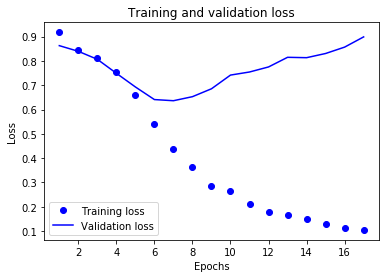

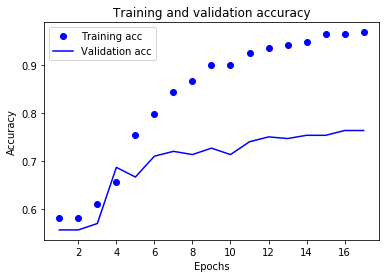

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict['attitude_acc']
val_acc = history_dict['val_attitude_acc']
loss = history_dict['attitude_loss']
val_loss = history_dict['val_attitude_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Returns results for training set**

In [ ]:
# returns results on the testing data
results = model.evaluate(testing_data, [testing_attitude, testing_tone, testing_type])
print(results)
#makes a list of all the predictions
ynew = model.predict(testing_data)[0]
import sklearn
ynew = [np.argmax(p) for p in ynew]


ytrue = [np.argmax(p) for p in testing_attitude]
print("ATTITUDE DATA")
print(sklearn.metrics.classification_report(ytrue, ynew, digits = 4))


#makes a list of all the predictions
ynew = model.predict(testing_data)[1]
ynew = [np.argmax(p) for p in ynew]


ytrue = [np.argmax(p) for p in testing_tone]
print("TONE DATA")
print(sklearn.metrics.classification_report(ytrue, ynew, digits = 4))


#makes a list of all the predictions
ynew = model.predict(testing_data)[2]
ynew = [np.argmax(p) for p in ynew]


ytrue = [np.argmax(p) for p in testing_type]
print("TYPE DATA")
print(sklearn.metrics.classification_report(ytrue, ynew, digits = 4))

597/597 [==============================] - 0s 443us/step
[3.003708174480266, 0.8841576601192979, 1.1509489963202422, 0.9686014898857679, 0.7872696822412449, 0.6750418770453039, 0.6934673372824588]
ATTITUDE DATA
              precision    recall  f1-score   support

           0     0.7403    0.7668    0.7533       223
           1     0.7500    0.3529    0.4800        34
           2     0.8200    0.8441    0.8319       340

    accuracy                         0.7873       597
   macro avg     0.7701    0.6546    0.6884       597
weighted avg     0.7862    0.7873    0.7825       597

TONE DATA
              precision    recall  f1-score   support

           0     0.3824    0.3514    0.3662        74
           1     1.0000    0.0455    0.0870        22
           2     0.4130    0.3654    0.3878        52
           3     0.6515    0.4943    0.5621        87
           4     0.7542    0.8842    0.8140       354
           5     1.0000    0.1250    0.2222         8

    accuracy      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Saving the predictions onto an excel file**

In [ ]:
from xlwt import Workbook
import xlwt
from google.colab import files
wb = Workbook()

sheet1 = wb.add_sheet('sheet 1')
for i in range(len(testing_attitude)):
  sheet1.write(i+1, 0, "Tweet " + str(i+1))
  sheet1.write(i+1, 1, str(ynew[i]+1))
  sheet1.write(i+1, 2, str(testing_select_2[i]+1))

wb.save('predictions.xls')
